In [0]:
import pandas as pd
import numpy as np 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [0]:
ratings = pd.read_csv('https://media.githubusercontent.com/media/techgymjp/techgym_ai_close/master/chapter15/datasets/anime-recommendations-database/rating.csv?token=AICRPGEZWKOQ3BX4WIOIZPC5N4WAK')
anime = pd.read_csv('https://raw.githubusercontent.com/techgymjp/techgym_ai_close/master/chapter15/datasets/anime-recommendations-database/anime.csv?token=AICRPGES3GBXVIRHWN44V6K5PBMEI')

In [3]:
ratings[:5]

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
anime[:5]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
# animeをmemberの値で並び替える
anime.sort_values('members', ascending= False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [6]:
# animeの基本統計量の確認
round(anime.describe(),2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


In [7]:
# ratingsの基本統計量の確認
round(ratings.describe(),2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


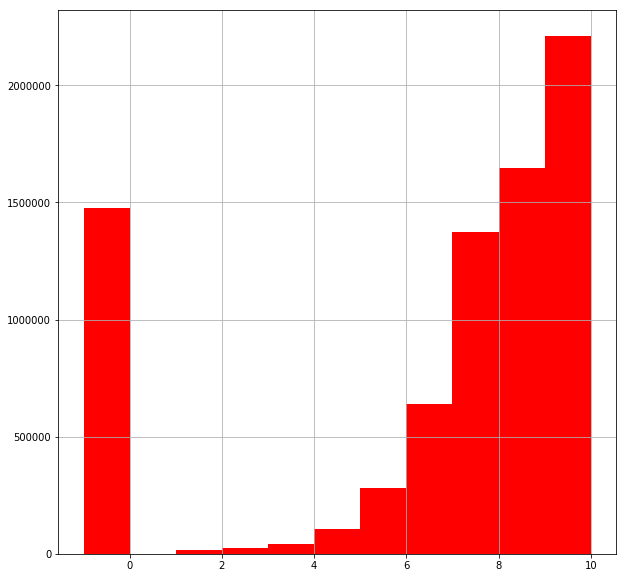

In [8]:
# ratingsのヒストグラムを作成
ratings['rating'].hist(bins=11, figsize=(10,10), color = 'red')

In [0]:
# membersの値が10,000より大きいデータのみに変更
anime = anime[anime['members'] > 1000]
anime[:5]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
# 欠損データの確認
anime.isnull().sum()

anime_id      0
name          0
genre         6
type         15
episodes      0
rating      150
members       0
dtype: int64

In [0]:
# 欠損データをデータセットから取り除く
anime = anime.dropna()
anime[:5]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
# raitingの値が0以上のみ残す
ratings = ratings[ratings.rating >= 0]
round(ratings.describe(),2)

,user_id,anime_id,rating
count,6337241.00,6337241.00,6337241.00
mean,36747.91,8902.87,7.81
std,21013.40,8882.00,1.57
min,1.00,1.00,1.00
25%,18984.00,1239.00,7.00
50%,36815.00,6213.00,8.00
75%,54873.00,14075.00,9.00
max,73516.00,34475.00,10.00


In [0]:
# animeとratingsの2つのデータフレームをマージさせる
mergeddf = ratings.merge(anime, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [0]:
# mergeddfの基本統計量の確認
round(mergeddf.describe(),2)

,user_id,anime_id,rating_user,rating,members
count,6315197.00,6315197.00,6315197.00,6315197.00,6315197.00
mean,36745.91,8901.45,7.81,7.68,185216.23
std,21014.31,8882.69,1.57,0.66,190976.19
min,1.00,1.00,1.00,2.00,1001.00
25%,18985.00,1222.00,7.00,7.29,47136.00
50%,36801.00,6213.00,8.00,7.70,117910.00
75%,54877.00,14123.00,9.00,8.16,257925.00
max,73516.00,34349.00,10.00,9.37,1013917.00


In [0]:
# 不必要な項目と重複項目を削除
mergeddf = mergeddf[['user_id','name','rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id','name'])
 
# head()で最初の5行を表示
mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


In [0]:
# データフレームのピボット
anime_pivot = mergeddf.pivot(index= 'name',columns='user_id',values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [0]:
# anime_pivotの最初の10行を表示
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,...,73477,73478,73479,73480,73481,73482,73483,73484,73485,73486,73487,73488,73489,73490,73491,73492,73493,73494,73495,73496,73497,73498,73499,73500,73501,73502,73503,73504,73505,73506,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&quot;0&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy: Parody Mode,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# データセットのタイトルをキーワードで検索
def searchanime(string):
    print(anime_pivot[anime_pivot.index.str.contains(string)].index[0:])
    
searchanime('Shingeki')

Index(['Crayon Shin-chan Movie 13: Densetsu wo Yobu Buriburi 3 Pun Dai Shingeki',
       'Shingeki no Bahamut: Genesis', 'Shingeki no Bahamut: Genesis Recap',
       'Shingeki no Kyojin', 'Shingeki no Kyojin Movie 1: Guren no Yumiya',
       'Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa',
       'Shingeki no Kyojin OVA', 'Shingeki no Kyojin Picture Drama',
       'Shingeki no Kyojin: Ano Hi Kara',
       'Shingeki no Kyojin: Kuinaki Sentaku', 'Shingeki! Kyojin Chuugakkou'],
      dtype='object', name='name')


In [0]:
# Scikit-learnのライブラリを利用
knn = NearestNeighbors(n_neighbors=9,algorithm= 'brute', metric= 'cosine')
 
# 前処理したデータセットでモデルを訓練
model_knn = knn.fit(anime_pivot_sparse)

In [0]:
# 「進撃の巨人」を見たユーザーへのオススメアニメ
Anime = 'Shingeki no Kyojin'

distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Shingeki no Kyojin:

1: Sword Art Online with distance: 0.3285534491894686
2: Tokyo Ghoul with distance: 0.386511994002511
3: No Game No Life with distance: 0.41119517642362835
4: Mirai Nikki (TV) with distance: 0.41453449483796523
5: Death Note with distance: 0.42526883654659386
6: Fullmetal Alchemist: Brotherhood with distance: 0.4435747187042025
7: Noragami with distance: 0.44850129757293233
8: Angel Beats! with distance: 0.45241224553754356
9: Steins;Gate with distance: 0.45581394011914267
10: Ao no Exorcist with distance: 0.46031572941749765
